In [4]:
import sys
sys.path.append('C:/Users/KimDongyoung/Desktop/Github/my_git/mygit/DEEPLEARNING/밑바닥부터시작하는딥러닝2')

import numpy as np
import matplotlib.pyplot as plt
from common.layers import *
import pickle
from common.time_layers import TimeEmbedding, TimeAffine, TimeSoftmaxWithLoss
from ptb import load_data
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [6]:
class LSTM:
  def __init__(self, Wx, Wh, b):
      '''

      Parameters
      ----------
      Wx: 입력 x에 대한 가중치 매개변수(4개분의 가중치가 담겨 있음)
      Wh: 은닉 상태 h에 대한 가장추 매개변수(4개분의 가중치가 담겨 있음)
      b: 편향（4개분의 편향이 담겨 있음）
      '''
      self.params = [Wx, Wh, b]
      self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
      self.cache = None

  def forward(self, x, h_prev, c_prev):
      Wx, Wh, b = self.params
      N, H = h_prev.shape

      A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

      f = A[:, :H]
      g = A[:, H:2*H]
      i = A[:, 2*H:3*H]
      o = A[:, 3*H:]

      f = sigmoid(f)
      g = np.tanh(g)
      i = sigmoid(i)
      o = sigmoid(o)

      c_next = f * c_prev + g * i
      h_next = o * np.tanh(c_next)

      self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
      return h_next, c_next

  def backward(self, dh_next, dc_next):
      Wx, Wh, b = self.params
      x, h_prev, c_prev, i, f, g, o, c_next = self.cache

      tanh_c_next = np.tanh(c_next)

      ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

      dc_prev = ds * f

      di = ds * g
      df = ds * c_prev
      do = dh_next * tanh_c_next
      dg = ds * i

      di *= i * (1 - i)
      df *= f * (1 - f)
      do *= o * (1 - o)
      dg *= (1 - g ** 2)

      dA = np.hstack((df, dg, di, do))

      dWh = np.dot(h_prev.T, dA)
      dWx = np.dot(x.T, dA)
      db = dA.sum(axis=0)

      self.grads[0][...] = dWx
      self.grads[1][...] = dWh
      self.grads[2][...] = db

      dx = np.dot(dA, Wx.T)
      dh_prev = np.dot(dA, Wh.T)

      return dx, dh_prev, dc_prev

In [7]:
# T개 분의 시계열 데이터를 한꺼번에 처리하는 TimeLSTM 계층
class TimeLSTM:
  def __init__(self, Wx, Wh, b , stateful=False):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.layers = None

    self.h, self.c = None, None   # hidden state, cell state
    self.dh = None
    self.stateful = stateful
  
  def forward(self, xs):
    Wx, Wh, b = self.params
    N, T, D = xs.shape
    H = Wh.shape[0]

    self.layers = []
    hs = np.empty((N, T, H), dtype='f')     # 출력값을 저장할 변수 hs를 초기화

    if not self.stateful or self.h is None:
      self.h = np.zeros((N, H), dtype='f')
    if not self.stateful or self.c is None:
      self.c = np.zeros((N, H), dtype='f')
    
    for t in range(T):
      layer = LSTM(*self.params)
      self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
      hs[:, t, :] = self.h

      self.layers.append(layer)
    
    return hs
  
  def backward(self, dhs):
    Wx, Wh, b = self.params
    N, T, H = dhs.shape
    D = Wx.shape[0]

    dxs = np.empty((N, T, D), dtype='f')
    dh, dc = 0, 0

    grads = [0, 0, 0]
    for t in reversed(range(T)):
      layer = self.layers[t]
      dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
      dxs[:, t, :] = dx
      for i, grad in enumerate(layer.grads):
        grads[i] += grad
    
    for i, grad in enumerate(grads):
      self.grads[i][...] = grad
    self.dh = dh
    return dxs
  
  def set_state(self, h, c=None):
    self.h, self.c = h, c
  
  # 상태 초기화
  def reset_state(self):
    self.h, self.c = None, None

In [8]:
class Rnnlm:
  def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
      V, D, H = vocab_size, wordvec_size, hidden_size
      rn = np.random.randn

      # 가중치 초기화
      embed_W = (rn(V, D) / 100).astype('f')
      lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
      lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
      lstm_b = np.zeros(4 * H).astype('f')
      affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
      affine_b = np.zeros(V).astype('f')

      # 계층 생성
      self.layers = [
          TimeEmbedding(embed_W),
          TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
          TimeAffine(affine_W, affine_b)
      ]
      self.loss_layer = TimeSoftmaxWithLoss()
      self.lstm_layer = self.layers[1] # TimeLSTM 계층을 가리킴

      # 모든 가중치와 기울기를 리스트에 모은다.
      self.params, self.grads = [], []
      for layer in self.layers:
          self.params += layer.params
          self.grads += layer.grads

  # 예측, softmax 계층 직전까지를 처리 
  def predict(self, xs):        
      for layer in self.layers:
          xs = layer.forward(xs)
      return xs

  def forward(self, xs, ts):
      score = self.predict(xs)
      loss = self.loss_layer.forward(score, ts)
      return loss

  def backward(self, dout=1):
      dout = self.loss_layer.backward(dout)
      for layer in reversed(self.layers):
          dout = layer.backward(dout)
      return dout

  def reset_state(self):
      self.lstm_layer.reset_state()
      
  def save_params(self, file_name='Rnnlm.pkl'):
      with open(file_name, 'wb') as f:
          pickle.dump(self.params, f)
          
  def load_params(self, file_name='Rnnlm.pkl'):
      with open(file_name, 'rb') as f:
          self.params = pickle.load(f)

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 10001.52
| 에폭 1 |  반복 21 / 1327 | 시간 4[s] | 퍼플렉서티 2467.64
| 에폭 1 |  반복 41 / 1327 | 시간 7[s] | 퍼플렉서티 1281.67
| 에폭 1 |  반복 61 / 1327 | 시간 11[s] | 퍼플렉서티 1026.38
| 에폭 1 |  반복 81 / 1327 | 시간 14[s] | 퍼플렉서티 846.34
| 에폭 1 |  반복 101 / 1327 | 시간 18[s] | 퍼플렉서티 674.12
| 에폭 1 |  반복 121 / 1327 | 시간 21[s] | 퍼플렉서티 679.64
| 에폭 1 |  반복 141 / 1327 | 시간 25[s] | 퍼플렉서티 622.47
| 에폭 1 |  반복 161 / 1327 | 시간 28[s] | 퍼플렉서티 590.04
| 에폭 1 |  반복 181 / 1327 | 시간 32[s] | 퍼플렉서티 601.96
| 에폭 1 |  반복 201 / 1327 | 시간 35[s] | 퍼플렉서티 511.48
| 에폭 1 |  반복 221 / 1327 | 시간 38[s] | 퍼플렉서티 494.65
| 에폭 1 |  반복 241 / 1327 | 시간 42[s] | 퍼플렉서티 452.99
| 에폭 1 |  반복 261 / 1327 | 시간 45[s] | 퍼플렉서티 476.56
| 에폭 1 |  반복 281 / 1327 | 시간 48[s] | 퍼플렉서티 459.14
| 에폭 1 |  반복 301 / 1327 | 시간 52[s] | 퍼플렉서티 396.98
| 에폭 1 |  반복 321 / 1327 | 시간 55[s] | 퍼플렉서티 340.36
| 에폭 1 |  반복 341 / 1327 | 시간 58[s] | 퍼플렉서티 400.43
| 에폭 1 |  반복 361 / 1327 | 시간 62[s] | 퍼플렉서티 412.47
| 에폭 1 |  반복 381 / 1327 | 시간 65[s] | 퍼플렉서티 340.98
| 에폭

c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54140 (\N{HANGUL SYLLABLE PEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KimDongyoung\AppData\Local\Program

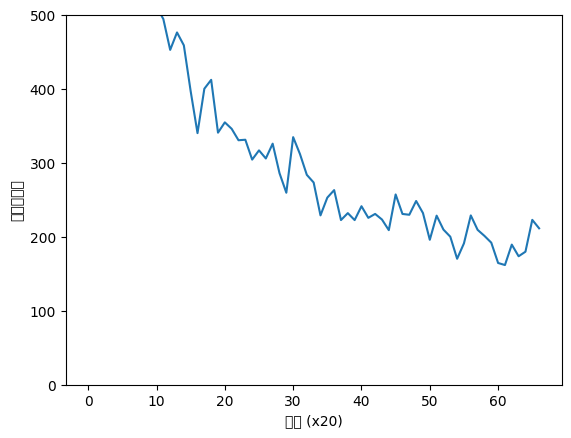

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  196.16160605251875


In [9]:
# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 1
max_grad = 0.2

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = load_data('train')
corpus_test, _, _ = load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성 
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)                       # 옵티마이저 생성, 학습률 20.0, SGD로 설정
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0, 500))

# 테스트 데이터로 평가
model.reset_state()                              # 이전 시간 단계의 은닉 상태, 셀 상태를 초기화하여 테스트 데이터에 대한 평가를 수행  
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

# 학습된 매개변수 저장
model.save_params()                          # 학습된 매개변수를 저장하여 나중에 사용할 수 있도록 함